# Diagramms and plots

In [71]:
# change to the root directory of the project
import os
if os.getcwd().split("/")[-1] == "examples":
    os.chdir('..')
print(os.getcwd())

/mnt/raid/data/anina/ScanDy


In [ ]:
import importlib
import os
import random

import matplotlib.patches as mpatches
from matplotlib.collections import PolyCollection
from matplotlib.colors import to_rgb
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns

from neurolib.optimize.evolution import Evolution
from neurolib.utils.parameterSpace import ParameterSpace

import scandy_pfc.models.ObjectModel as objectmodel_module
import scandy_pfc.models.model as base_model
import scandy_pfc.utils.dataclass as dataclass_module

In [73]:
dircl = ['xkcd:maroon', sns.color_palette("Dark2")[1], sns.color_palette("Dark2")[5], sns.color_palette("Dark2")[6] ]
mcl = ['xkcd:blue', 'xkcd:red']
MODEL = "obj" 
FEATURESET = "DG2E_cb" 

In [74]:
importlib.reload(dataclass_module)
Dataset = dataclass_module.Dataset
importlib.reload(base_model)
importlib.reload(objectmodel_module)
ObjectModel = objectmodel_module.ObjectModel

In [ ]:
#Parameters to change for each dataset
test_group = "young" #"old" "pd_on", "pd_off"
dataframe_files = {
    "young": 'df_all_fovs_psycsci.csv',
    "old": 'df_all_fovs_psycsci.csv',
    "pd_on": 'df_all_fovs_psycsci.csv',
    "pd_off": 'df_all_fovs_psycsci.csv'
}
folder_path = "/mnt/raid/data/anina/ScanDy/PictureExample/picture/"

#####
evolution_name_dill = f"saved_evolution_obj_DG2E_cb_picturedata"
simulate_with_best_params = f"best_params_obj_DG2E_cb_picturedata"

In [76]:
files = [os.path.splitext(f)[0] for f in os.listdir(folder_path) 
         if os.path.isfile(os.path.join(folder_path, f)) and f.endswith(".png")]

In [77]:
# full imagelist
# imglist = sorted(files)
imglist = sorted(['shoebill', 'fish', 'pedestrian', 'toaster', 'waterbottle', 'sealion', 'elevatorEmpty', 'watercooler', 'fly', 'chimpanzee', 'trinkvogel2'])

random.seed(12345)
#trainlist = sorted(random.sample(imglist, 10))
trainlist = sorted(random.sample(imglist, 2))
testlist = sorted([vidname for vidname in imglist if vidname not in trainlist])
print("trainlist = ", trainlist, "\ntestlist =", testlist)
print(len(trainlist), len(imglist))


VidCom = {}

for key, gt_foveation_df in dataframe_files.items():
    datadict = {
        "PATH": "PictureExample/",
        'FPS': 30,
        'PX_TO_DVA': (47.7 * 0.8) / 1920,
        'FRAMES_ALL_VIDS': 150,
        'gt_foveation_df': gt_foveation_df,
        'dataformat': 'picture', #video
        'NAME_COL': 'scene',
        'trainset': trainlist,
        'testset': testlist,
        'used_videos': imglist
    }
    ds = Dataset(datadict)
    # For faster processing during testing, resized the videos to smaller dimensions
    ds.VID_SIZE_Y, ds.VID_SIZE_X = 540, 960
    VidCom[key] = ds
    


trainlist =  ['chimpanzee', 'shoebill'] 
testlist = ['elevatorEmpty', 'fish', 'fly', 'pedestrian', 'sealion', 'toaster', 'trinkvogel2', 'waterbottle', 'watercooler']
2 11
Video column is set to: scene
Video column is set to: scene
Video column is set to: scene
Video column is set to: scene


### Analyzisng ground truth of the data

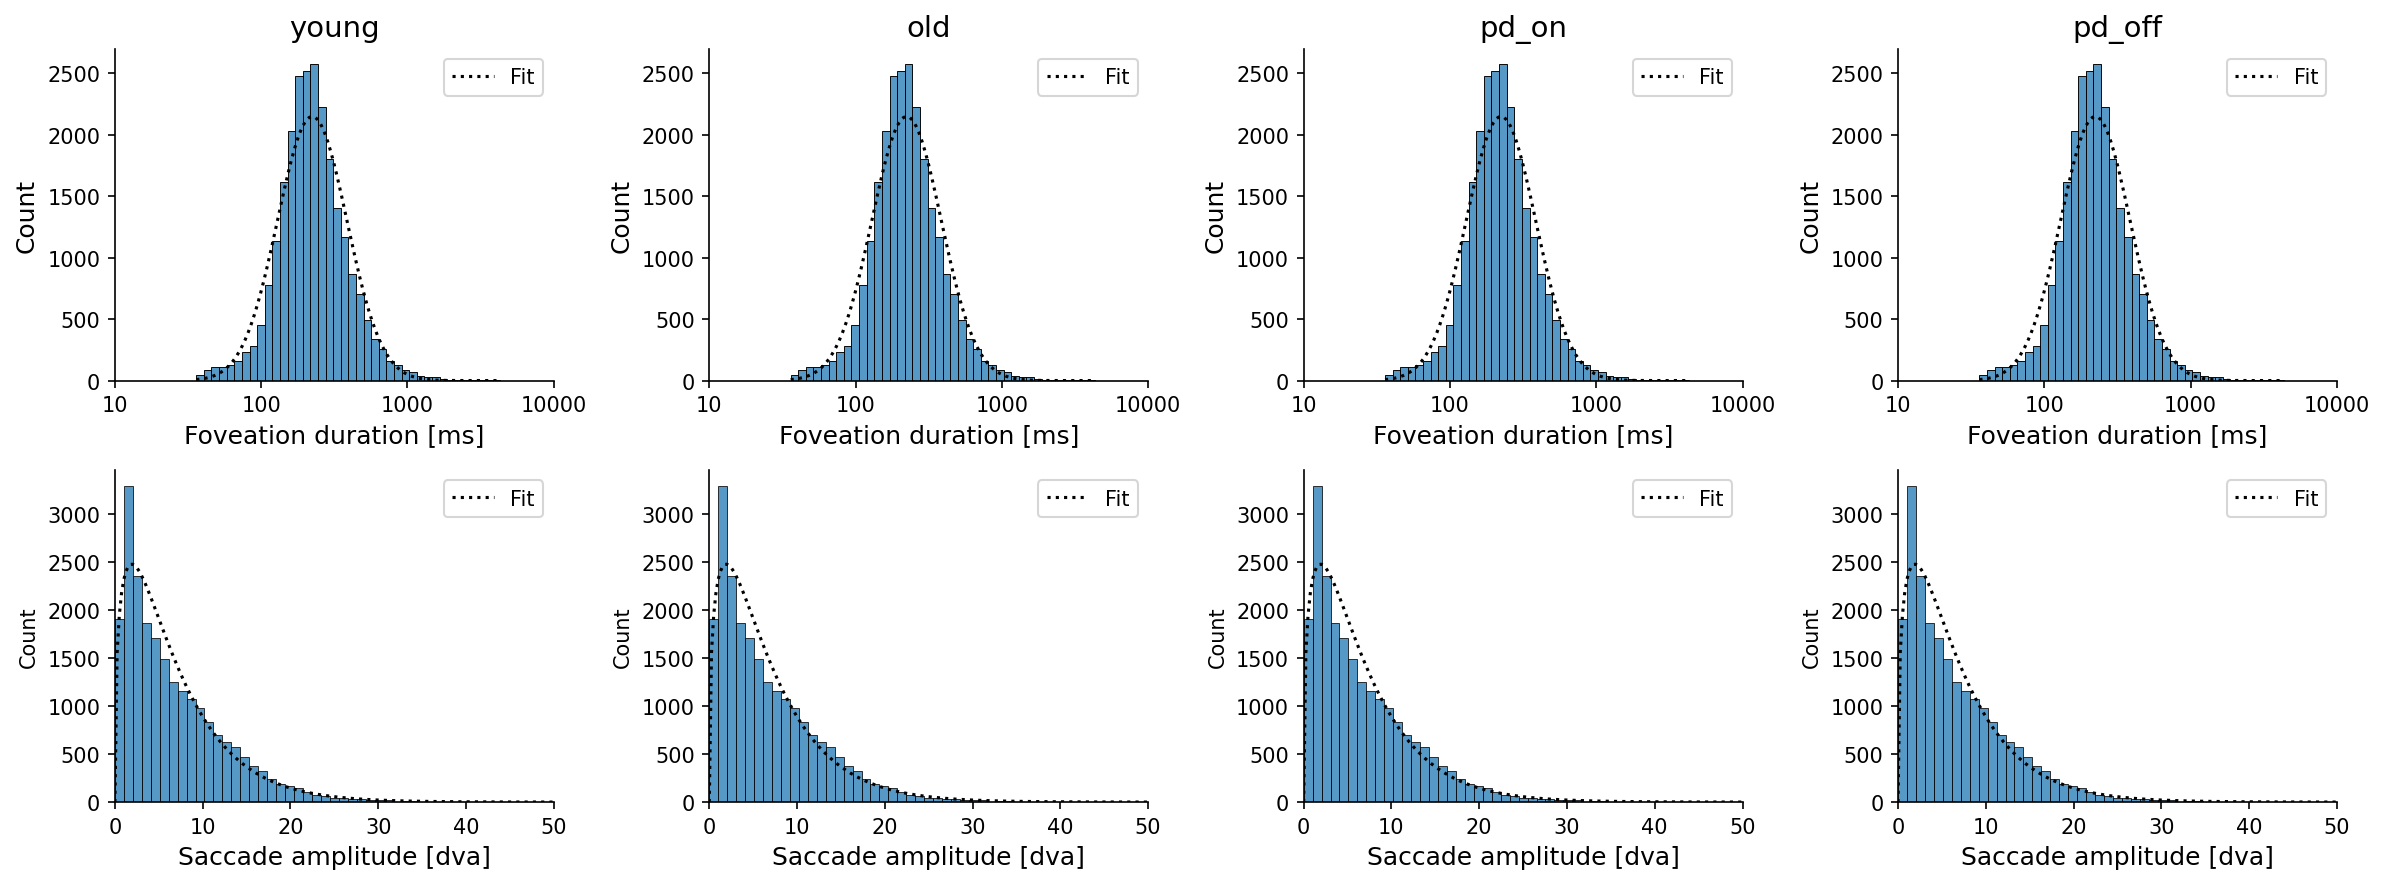

young dataset:
  Foveation duration fit (log10 space): (2.3488210608713076, 0.2372939551007589)
  Saccade amplitude fit: (1.4001012737974579, 0, 4.792045313836195)
old dataset:
  Foveation duration fit (log10 space): (2.3488210608713076, 0.2372939551007589)
  Saccade amplitude fit: (1.4001012737974579, 0, 4.792045313836195)
pd_on dataset:
  Foveation duration fit (log10 space): (2.3488210608713076, 0.2372939551007589)
  Saccade amplitude fit: (1.4001012737974579, 0, 4.792045313836195)
pd_off dataset:
  Foveation duration fit (log10 space): (2.3488210608713076, 0.2372939551007589)
  Saccade amplitude fit: (1.4001012737974579, 0, 4.792045313836195)


In [78]:
fig, axs = plt.subplots(2, len(VidCom.keys()), dpi=150, figsize=(16, 6), sharey=False)

for col, key in enumerate(VidCom.keys()):
    data_set = VidCom[key]
    
    # Ground truth
    gt_amp_dva = data_set.gt_foveation_df["sac_amp_dva"].dropna().values
    gt_amp_dva = gt_amp_dva[gt_amp_dva > 0.5]
    gt_dur_ms = data_set.gt_foveation_df["duration_ms"].dropna().values
    
    # Fit with Gamma-function for Saccade amplitude
    ampX = np.linspace(0, 50, 200)
    ampfit = stats.gamma.fit(gt_amp_dva, floc=0)
    ampPDF = stats.gamma.pdf(ampX, *ampfit)

    # Fit with Log-normal approximation for Foveation duration
    dur_log = np.log10(gt_dur_ms)
    durX = np.linspace(dur_log.min(), dur_log.max(), 200)
    durfit = stats.norm.fit(dur_log)
    durPDF = stats.norm.pdf(durX, *durfit)

    # Scale PDFs to histogram
    bins_dur = 40
    counts_dur, bin_edges_dur = np.histogram(dur_log, bins=bins_dur)
    bin_width_dur = bin_edges_dur[1] - bin_edges_dur[0]
    durPDF_scaled = durPDF * len(dur_log) * bin_width_dur

    bins_amp = np.linspace(0, 50, 50)
    counts_amp, bin_edges_amp = np.histogram(gt_amp_dva, bins=bins_amp)
    bin_width_amp = bin_edges_amp[1] - bin_edges_amp[0]
    ampPDF_scaled = ampPDF * len(gt_amp_dva) * bin_width_amp

    # Plot Foveation duration
    sns.histplot(dur_log, bins=bins_dur, kde=False, ax=axs[0, col])
    axs[0, col].plot(durX, durPDF_scaled, color='k', ls=':', label='Fit')
    axs[0, col].set_xticks([1, 2, 3, 4])
    axs[0, col].set_xticklabels([10, 100, 1000, 10000])
    axs[0, col].set_xlabel('Foveation duration [ms]', size=12)
    axs[0, col].set_ylabel('Count', size=12)
    axs[0, col].set_title(key, size=14)
    axs[0, col].tick_params(labelsize=10)
    axs[0, col].legend()

    # Plot Saccade amplitude
    sns.histplot(gt_amp_dva, bins=bins_amp, kde=False, ax=axs[1, col])
    axs[1, col].plot(ampX, ampPDF_scaled, color='k', ls=':', label='Fit')
    axs[1, col].set_xlabel('Saccade amplitude [dva]', size=12)
    axs[1, col].set_xlim([0, 50])
    axs[1, col].tick_params(labelsize=10)
    axs[1, col].legend()

sns.despine()
plt.tight_layout()
plt.show()

# Optionally, print fit parameters for each dataset
for key in VidCom.keys():
    data_set = VidCom[key]
    gt_amp_dva = data_set.gt_foveation_df["sac_amp_dva"].dropna().values
    gt_amp_dva = gt_amp_dva[gt_amp_dva > 0.5]
    gt_dur_ms = data_set.gt_foveation_df["duration_ms"].dropna().values
    ampfit = stats.gamma.fit(gt_amp_dva, floc=0)
    durfit = stats.norm.fit(np.log10(gt_dur_ms))
    print(f"{key} dataset:")
    print("  Foveation duration fit (log10 space):", durfit)
    print("  Saccade amplitude fit:", ampfit)

TODO: Change Number of iterations if more simulated data available. 

MainProcess root INFO     Assuming parameter kind "bound"
MainProcess root INFO     weightList not set, assuming single fitness value to be maximized.
MainProcess root INFO     Trajectory Name: results-2025-12-04-15H-26M-42S
MainProcess root INFO     Storing data to: ./data/hdf/evolution.hdf
MainProcess root INFO     Trajectory Name: results-2025-12-04-15H-26M-42S
MainProcess root INFO     Number of cores: 256
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/evolution.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Evolution: Using algorithm: adaptive
/home/aninam/miniconda3/envs/myenv310/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/aninam


  YOUNG GROUP

Parameters (mean ± std | top):
  ddm_thres   :  2.158 ±   0.31 |  2.639
  ddm_sig     :  0.137 ±  0.014 |  0.149
  att_dva     :  11.34 ±   3.65 |  16.73
  ior_decay   :  127.0 ±   55.7 |  176.1
  ior_inobj   :   0.53 ±   0.12 |   0.54

Fitness components:
  d_FD:  0.171 ±   0.05 | top:  0.188
  d_SA:   0.34 ±  0.052 | top:  0.307

Foveation categories (B, D, I, R):
  Train: [0.47029753 0.25156276 0.08230517 0.19583454]
  Test:  [0.3776202  0.39400361 0.06588633 0.16248986]
  Ratio: [0.85617998 3.09929343 0.21926347 1.23725065]

  OLD GROUP

Parameters (mean ± std | top):
  ddm_thres   :  2.158 ±   0.31 |  2.639
  ddm_sig     :  0.137 ±  0.014 |  0.149
  att_dva     :  11.34 ±   3.65 |  16.73
  ior_decay   :  127.0 ±   55.7 |  176.1
  ior_inobj   :   0.53 ±   0.12 |   0.54

Fitness components:
  d_FD:  0.171 ±   0.05 | top:  0.188
  d_SA:   0.34 ±  0.052 | top:  0.307

Foveation categories (B, D, I, R):
  Train: [0.47029753 0.25156276 0.08230517 0.19583454]
  Test:  [0.

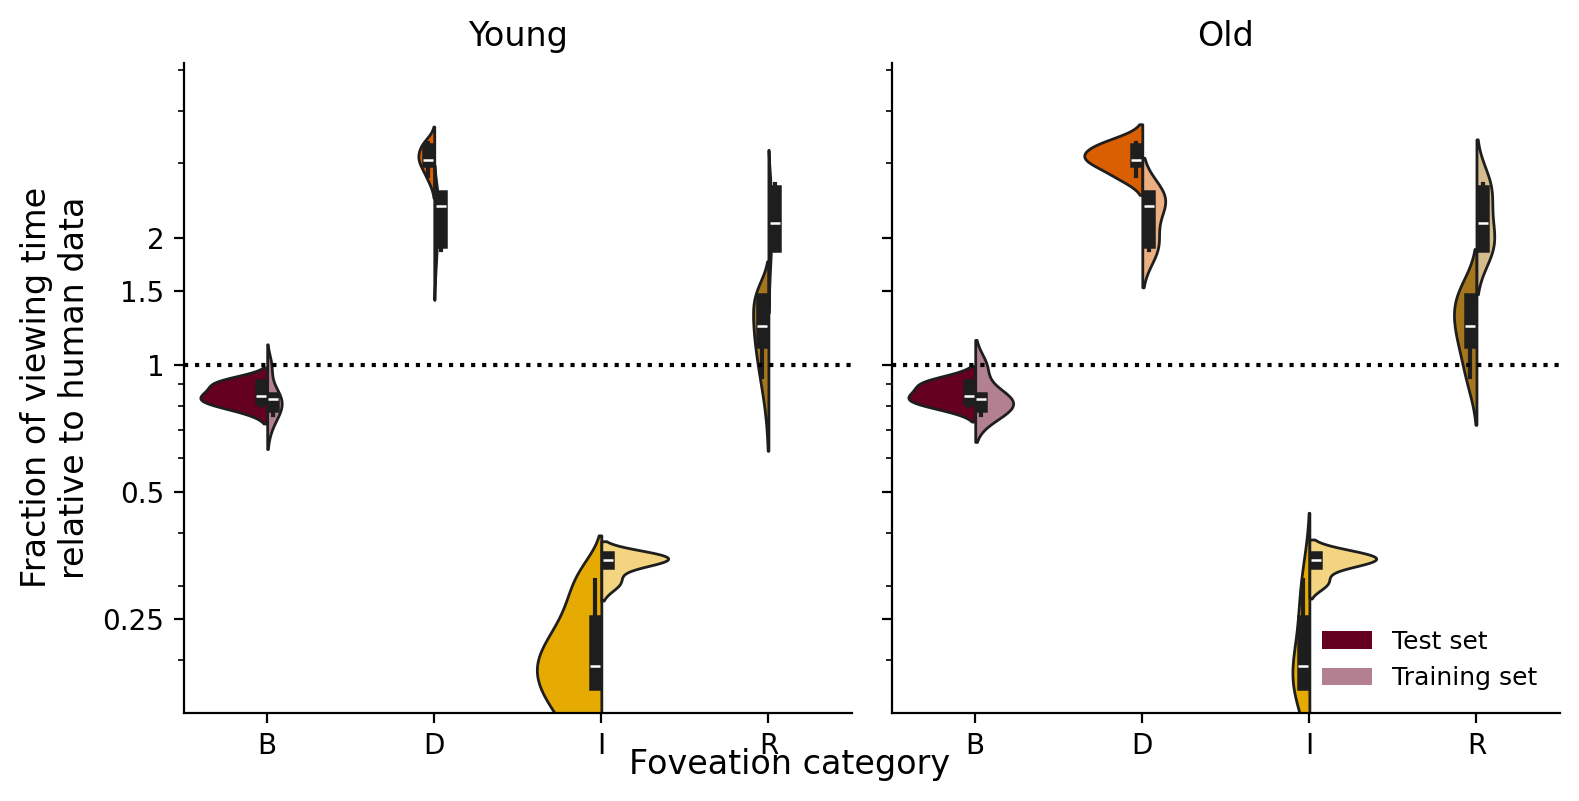

In [80]:
iterations = 5

fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 4), dpi=200)
report_par_decimals = [3, 3, 2, 1, 2]


mean_fovcats_train = {}
mean_fovcats_test = {}
    
for ax_i, key in enumerate(['young', 'old']):
    ax = axes[ax_i]
    
    subjects_fovcat_train = list(VidCom[key].get_fovcat_ratio("train").values())
    subjects_fovcat_test = list(VidCom[key].get_fovcat_ratio("test").values())

    # dummy evol overwritten later
    evol = Evolution(lambda x: x, ParameterSpace(['mock'], [[0, 1]]))
    
    DILLNAME = f'{evolution_name_dill}_{key}.dill'
    model = ObjectModel(VidCom[key])
    parameters = ['ddm_thres', 'ddm_sig', 'att_dva', 'ior_decay', 'ior_inobj']

    evol = evol.loadEvolution(f'results/{DILLNAME}')  # overwrite dummy evol
    df_evol = evol.dfEvolution(outputs=True).copy()
    df_top = df_evol.sort_values('score', ascending=False)[:iterations]

    train_fovcats = []
    test_fovcats = []
    mean_fovcats_train_list = []
    mean_fovcats_test_list = []
    for i in range(iterations):
        df_res = pd.read_csv(f'results/{simulate_with_best_params}_{key}_{i}.csv.gz', compression='gzip')
        model.result_df = df_res[df_res['video'].isin(VidCom[key].trainset)]
        train_fovcats.append(np.array(list(model.get_fovcat_ratio().values())))
        model.result_df = df_res[df_res['video'].isin(VidCom[key].testset)]
        test_fovcats.append(np.array(list(model.get_fovcat_ratio().values())))
    
    df_top['train_fov_cat'] = train_fovcats
    df_top['test_fov_cat'] = test_fovcats

    print(f"\n{'='*60}")
    print(f"  {key.upper()} GROUP")
    print(f"{'='*60}")
    print("\nParameters (mean ± std | top):")
    for i, par in enumerate(parameters):
        top_par = round(df_top[par].iloc[0], report_par_decimals[i])
        mean_par = round(df_top[par].mean(), report_par_decimals[i])
        std_par = round(df_top[par].std(), report_par_decimals[i])
        print(f"  {par:12s}: {mean_par:6} ± {std_par:6} | {top_par:6}")
    
    print("\nFitness components:")
    print(f"  d_FD: {round(df_top['f0'].mean(), 3):6} ± {round(df_top['f0'].std(), 3):6} | top: {round(df_top['f0'].iloc[0], 3):6}")
    print(f"  d_SA: {round(df_top['f1'].mean(), 3):6} ± {round(df_top['f1'].std(), 3):6} | top: {round(df_top['f1'].iloc[0], 3):6}")

    fovcats_train = [df_top['train_fov_cat'].iloc[indv] for indv in range(iterations)]
    mean_fovcats_train_list.append(np.mean(np.array(fovcats_train), axis=0))
    train_rel_fovcat = [df_top['train_fov_cat'].iloc[indv] / np.array(subjects_fovcat_train) for indv in range(iterations)]
    
    fovcats_test = [df_top['test_fov_cat'].iloc[indv] for indv in range(iterations)]
    mean_fovcats_test_list.append(np.mean(np.array(fovcats_test), axis=0))
    test_rel_fovcat = [df_top['test_fov_cat'].iloc[indv] / np.array(subjects_fovcat_test) for indv in range(iterations)]
    
    print("\nFoveation categories (B, D, I, R):")
    print(f"  Train: {np.mean(np.array(fovcats_train), axis=0)}")
    print(f"  Test:  {np.mean(np.array(fovcats_test), axis=0)}")
    print(f"  Ratio: {np.mean(np.array(fovcats_test), axis=0) / np.array(subjects_fovcat_test)}")
    
    df_train_fovcats_rel_gt = pd.DataFrame(
        index=[f'Indv. Top {t}' for t in range(iterations)],
        columns=['B', 'D', 'I', 'R'], 
        data=train_rel_fovcat
    ).assign(Data='training set')
    
    df_test_fovcats_rel_gt = pd.DataFrame(
        index=[f'Indv. Top {t}' for t in range(iterations)],
        columns=['B', 'D', 'I', 'R'], 
        data=test_rel_fovcat
    ).assign(Data='test set')
    
    cdf = pd.concat([df_test_fovcats_rel_gt, df_train_fovcats_rel_gt])
    mdf = pd.melt(cdf, id_vars=['Data'], var_name='fov_cat')

    sns.violinplot(x="fov_cat", y="value", hue="Data", data=mdf, ax=ax, split=True, 
                   linewidth=1, palette={"test set": dircl[0], "training set": ".85"})
    
    handles = []
    for ind, violin in enumerate(ax.findobj(PolyCollection)):
        rgb = to_rgb(dircl[ind // 2])
        if ind % 2 != 0:
            rgb = 0.5 + 0.5 * np.array(rgb) 
        violin.set_facecolor(rgb)
        handles.append(plt.Rectangle((0, 0), 0, 0, facecolor=rgb, edgecolor=rgb))
    
    ax.set_yscale('log')
    ax.set_ylim(0.15, 5.2)
    ax.set_yticks([0.25, 0.5, 1, 1.5, 2])
    ax.set_yticklabels([0.25, 0.5, 1, 1.5, 2])
    ax.axhline(1, color='k', ls=':')

    if ax_i == 0:
        ax.set_ylabel('Fraction of viewing time\nrelative to human data', size=12)
    else:
        ax.set_ylabel('')
    
    if ax_i == 1:  
        legend_handles = [
            Patch(facecolor=to_rgb(dircl[0]), edgecolor='none', label="Test set"),
            Patch(facecolor=0.5 + 0.5*np.array(to_rgb(dircl[0])), edgecolor='none', label="Training set")
        ]
        ax.legend(
            bbox_to_anchor=(1, 0), loc='lower right',
            frameon=False,
            handles=legend_handles,
            title="", fontsize=9
        )
    else:
        ax.get_legend().remove()
    
    ax.set_xlabel('')
    ax.set_title(f'{key.capitalize()}')
    mean_fovcats_test[key]=mean_fovcats_test_list
    mean_fovcats_train[key]=mean_fovcats_train_list
print(f"\n{'='*60}\n")
fig.text(0.5, 0.02, 'Foveation category', size=12, ha='center')
plt.tight_layout()
sns.despine()
plt.show()

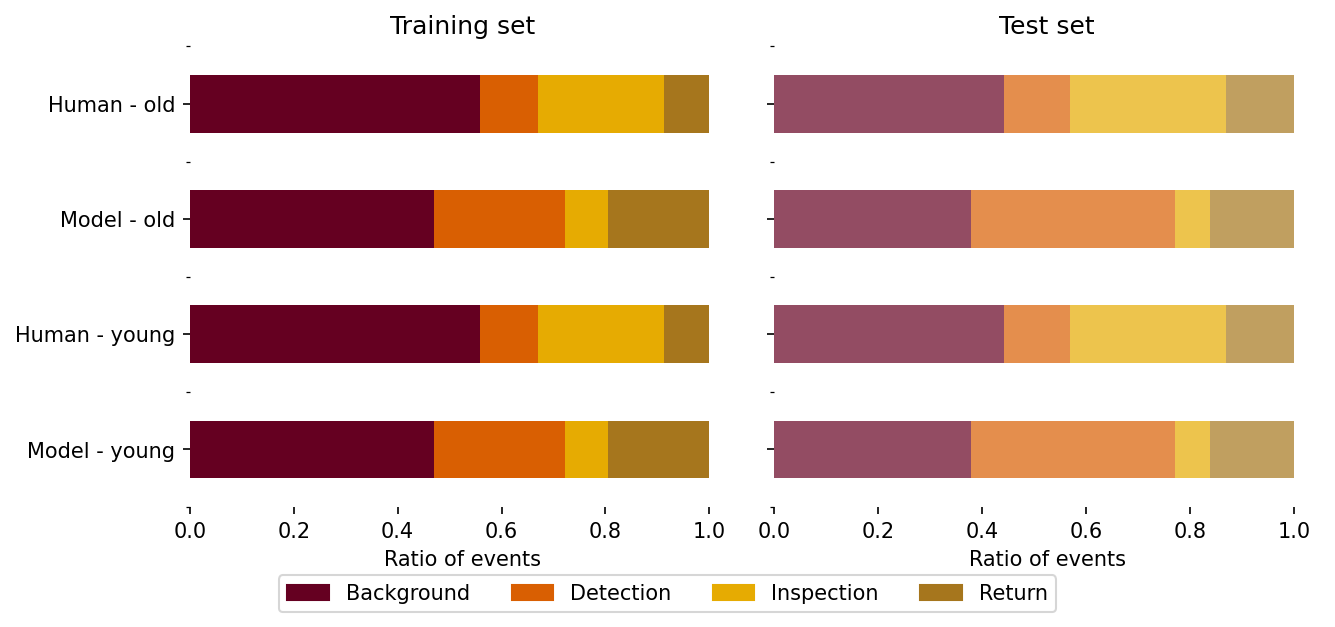

In [81]:
train_data = []
test_data = []
labels = []

for key in ['young', 'old']: #TODO: VidCom.keys()
    # Get human data
    subjects_fovcat_train = list(VidCom[key].get_fovcat_ratio("train").values())
    subjects_fovcat_test = list(VidCom[key].get_fovcat_ratio("test").values())
    
    train_data.append(mean_fovcats_train[key][0].tolist())
    test_data.append(mean_fovcats_test[key][0].tolist())
    train_data.append(subjects_fovcat_train)
    test_data.append(subjects_fovcat_test)
    labels.extend([f'Model - {key}', f'Human - {key}'])


df_fovcats_train = pd.DataFrame(
    index=labels,  
    columns=['B', 'D', 'I', 'R'],
    data=train_data
)

df_fovcats_test = pd.DataFrame(
    index=labels, 
    columns=['B', 'D', 'I', 'R'],
    data=test_data
)

# Create legend handles
legend_handles = [
    mpatches.Patch(color=dircl[0], label='Background'),
    mpatches.Patch(color=dircl[1], label='Detection'),
    mpatches.Patch(color=dircl[2], label='Inspection'),
    mpatches.Patch(color=dircl[3], label='Return'),
]

fig, axes = plt.subplots(1, 2, figsize=(9, 4), dpi=150, sharey=True)

# Training set
df_fovcats_train.plot.barh(
    stacked=True, ax=axes[0], rot=0, legend=False, color=dircl
)
axes[0].set_frame_on(False)
axes[0].set_xlabel('Ratio of events')
axes[0].set_title('Training set')

# Test set
df_fovcats_test.plot.barh(
    stacked=True, ax=axes[1], rot=0, legend=False, color=dircl, alpha=0.7
)
axes[1].set_frame_on(False)
axes[1].set_xlabel('Ratio of events')
axes[1].set_title('Test set')

fig.legend(
    handles=legend_handles,
    loc='lower center',     
    ncol=4,                 
    bbox_to_anchor=(0.5, -0.05)
)

plt.tight_layout()
plt.show()